## SHOR ALGORİTMASI


Shor algoritması, polinom zamanında tamsayıları çarpanlarına ayırmasıyla ünlüdür. En iyi bilinen klasik algoritma, iki asal sayının çarpımını çarpanlarına ayırmak için polinomdan daha uzun bir süre gerektirdiğinden, yaygın olarak kullanılan şifreleme protokolü RSA, yeterince büyük tamsayılar için çarpanlarına ayırmanın imkansız olmasına dayanır.

Bu bölümde, Shor algoritmasının kuantum kısmına odaklanacağız, bu kısım aslında _periyot bulma_ problemini çözmektedir. Faktörleme problemi polinom zamanında periyot bulma problemine dönüştürülebileceğinden, verimli bir periyot bulma algoritması da tamsayıları verimli bir şekilde faktörlemek için kullanılabilir. Şimdilik, $a^x\bmod N$'nin periyodunu verimli bir şekilde hesaplayabilirsek, çarpanlarına da verimli bir şekilde ayırabileceğimizi göstermek yeterlidir. Periyot bulma kendi başına değerli bir problem olduğundan, önce bunu çözeceğiz, ardından 5. bölümde bunun çarpanlarına ayırmak için nasıl kullanılabileceğini tartışacağız.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import math
from numpy.random import randint
import pandas as pd
from fractions import Fraction
print("Imports Successful")

Imports Successful


## 1. Periyot Bulma Problemi

Periyodik fonksiyona bakalım:

$$ f(x) = a^x \bmod{N}$$

<details>
    <summary>Hatırlatma: Modulo &amp; Modüler Aritmetik (Genişletmek için buraya tıklayın)</summary>

Modulo işlemi (kısaltması ‘mod’) basitçe bir sayıyı başka bir sayıya böldüğümüzde kalanı bulmak anlamına gelir. Örneğin:

$$ 17 \bmod 5 = 2 $$

Çünkü $17 \div 5 = 3$ ve kalanı $2$'dir. (yani $17 = (3\times 5) + 2$). Python'da modül işlemi <code>%</code> sembolü ile gösterilir.

Bu davranış, sayıların belirli bir değere (modül) ulaştıktan sonra “dönüş yaptığı” <a href="https://en.wikipedia.org/wiki/Modular_arithmetic">modüler aritmetik</a>'te kullanılır. Modüler aritmetik kullanarak şöyle yazabiliriz:

$$ 17 = 2 \pmod 5$$

Burada $\pmod 5$'in tüm denkleme uygulandığını unutmayın (parantez içinde olduğu için), yukarıdaki denklemde olduğu gibi sadece denklemin sol tarafına uygulanmadığını unutmayın.
</details>


burada $a$ ve $N$ pozitif tamsayılar olup, $a$ $N$'den küçüktür ve bunların ortak çarpanları yoktur. Periyot veya sıra ($r$), aşağıdaki koşulu sağlayan en küçük (sıfır olmayan) tamsayıdır:

$$a^r \bmod N = 1 $$ 

Bu fonksiyonun bir örneğini aşağıdaki grafikte görebiliriz. Noktalar arasındaki çizgiler, periyodikliği görmek için yardımcı olmak amacıyla çizilmiştir ve x işaretleri arasındaki ara değerleri temsil etmez.

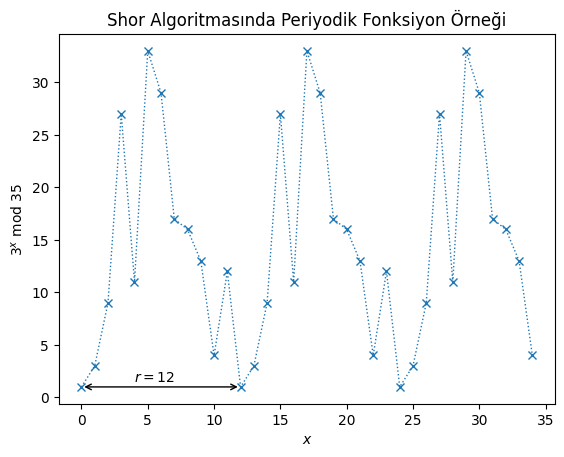

In [7]:
N = 35
a = 3

# Çizim verilerini hesaplayın
xvals = np.arange(35)
yvals = [np.mod(a**x, N) for x in xvals]

# Matplotlib kullanarak güzel bir şekilde görüntüleyin
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel=f'${a}^x$ mod ${N}$',
       title="Shor Algoritmasında Periyodik Fonksiyon Örneği")
try: # grafikte r'yi çiz
    r = yvals[1:].index(1) + 1
    plt.annotate('', xy=(0,1), xytext=(r,1),
                 arrowprops=dict(arrowstyle='<->'))
    plt.annotate(f'$r={r}$', xy=(r/3,1.5))
except ValueError:
    print('Periyot bulunamadı, < N yi kontrol edin ve ortak faktörler yok')

## 2. Çözüm

Shor'un çözümü, birim operatör üzerinde kuantum faz tahmini kullanmaktı:

$$ U|y\rangle \equiv |ay \bmod N \rangle $$

Bunun nasıl yararlı olduğunu görmek için, U'nun özdurumunun nasıl görünebileceğini inceleyelim. $|1\rangle$ durumunda başlarsak, U'nun her ardışık uygulaması kayıt durumumuzu $a \pmod N$ ile çarpacak ve $r$ uygulamadan sonra tekrar $|1\rangle$ durumuna ulaşacağız. Örneğin, $a = 3$ ve $N = 35$ olduğunda:


$$\begin{aligned}
U|1\rangle &= |3\rangle & \\
U^2|1\rangle &= |9\rangle \\
U^3|1\rangle &= |27\rangle \\
& \vdots \\
U^{(r-1)}|1\rangle &= |12\rangle \\
U^r|1\rangle &= |1\rangle 
\end{aligned}$$

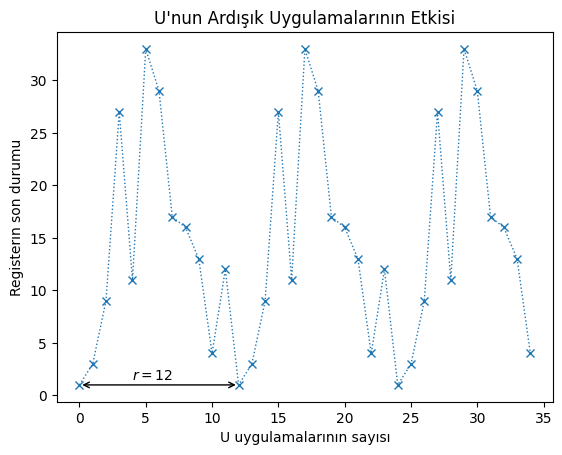

In [8]:
ax.set(xlabel='U uygulamalarının sayısı',
       ylabel='Register''ın son durumu',
       title="U'nun Ardışık Uygulamalarının Etkisi")
fig

Bu döngüdeki durumların süperpozisyonu ($|u_0\rangle$) $U$'nun özdurumu olacaktır:

$$|u_0\rangle = \tfrac{1}{\sqrt{r}}\sum_{k=0}^{r-1}{|a^k \bmod N\rangle} $$

<details>
    <summary>Genişletmek için tıklayın: a = 3 ve N=35 ile örnek</summary>

$$\begin{aligned}
|u_1\rangle &= \tfrac{1}{\sqrt{12}}(|1\rangle + e^{-\tfrac{2\pi i}{12}}|3\rangle + e^{-\tfrac{4\pi i}{12}}|9\rangle \dots + e^{-\tfrac{20\pi i}{12}}|4\rangle + e^{-\tfrac{22\pi i}{12}}|12\rangle) \\[10pt]
U|u_1\rangle &= \tfrac{1}{\sqrt{12}}(|3\rangle + e^{-\tfrac{2\pi i}{12}}|9\rangle + e^{-\tfrac{4\pi i}{12}}|27\rangle \dots + e^{-\tfrac{20\pi i}{12}}|12\rangle + e^{-\tfrac{22\pi i}{12}}|1\rangle) \\[10pt]
U|u_1\rangle &= e^{\tfrac{2\pi i}{12}}\cdot\tfrac{1}{\sqrt{12}}(e^{\tfrac{-2\pi i}{12}}|3\rangle + e^{-\tfrac{4\pi i}{12}}|9\rangle + e^{-\tfrac{6\pi i}{12}}|27\rangle \dots + e^{-\tfrac{22\pi i}{12}}|12\rangle + e^{-\tfrac{24\pi i}{12}}|1\rangle) \\[10pt]
U|u_1\rangle &= e^{\tfrac{2\pi i}{12}}|u_1\rangle
\end{aligned}$$

(Fazın paydasında $r = 12$'nin göründüğünü görebiliriz.)

</details>

Bu, $r$ içerdiği için özellikle ilginç bir özdeğer. Aslında, $r$ hesaplama temeli durumları arasındaki faz farklarının eşit olmasını sağlamak için dahil edilmelidir. Bu davranışı gösteren tek özdurum bu değildir; bunu daha da genelleştirmek için, bu faz farkına bir tamsayı olan $s$'yi çarpabiliriz, bu da özdeğerimizde görünecektir:

$$\begin{aligned}
|u_s\rangle &= \tfrac{1}{\sqrt{r}}\sum_{k=0}^{r-1}{e^{-\tfrac{2\pi i s k}{r}}|a^k \bmod N\rangle}\\[10pt]
U|u_s\rangle &= e^{\tfrac{2\pi i s}{r}}|u_s\rangle 
\end{aligned}
$$

<details>
    <summary>Genişletmek için tıklayın: a = 3 ve N=35 ile örnek</summary>

$$\begin{aligned}
|u_s\rangle &= \tfrac{1}{\sqrt{12}}(|1\rangle + e^{-\tfrac{2\pi i s}{12}}|3\rangle + e^{-\tfrac{4\pi i s}{12}}|9\rangle \dots + e^{-\tfrac{20\pi i s}{12}}|4\rangle + e^{-\tfrac{22\pi i s}{12}}|12\rangle) \\[10pt]
U|u_s\rangle &= \tfrac{1}{\sqrt{12}}(|3\rangle + e^{-\tfrac{2\pi i s}{12}}|9\rangle + e^{-\tfrac{4\pi i s}{12}}|27\rangle \dots + e^{-\tfrac{20\pi i s}{12}}|12\rangle + e^{-\tfrac{22\pi i s}{12}}|1\rangle) \\[10pt]
U|u_s\rangle &= e^{\tfrac{2\pi i s}{12}}\cdot\tfrac{1}{\sqrt{12}}(e^{-\tfrac{2\pi i s}{12}}|3\rangle + e^{-\tfrac{4\pi i s}{12}}|9\rangle + e^{-\tfrac{6\pi i s}{12}}|27\rangle \dots + e^{-\tfrac{22\pi i s}{12}}|12\rangle + e^{-\tfrac{24\pi i s}{12}}|1\rangle) \\[10pt]
U|u_s\rangle &= e^{\tfrac{2\pi i s}{12}}|u_s\rangle
\end{aligned}$$

</details>


Şimdi, $0 \leq s \leq r-1$ olan her tamsayı değeri $s$ için benzersiz bir özdurumumuz var. Çok kullanışlı bir şekilde, tüm bu özdurumları toplarsak, farklı fazlar $|1\rangle$ hariç tüm hesaplama temel durumlarını iptal eder:


$$ \tfrac{1}{\sqrt{r}}\sum_{s=0}^{r-1} |u_s\rangle = |1\rangle$$


<details>
    <summary>Genişletmek için tıklayın: a = 7 ve N = 15 ile örnek</summary>

Bunun için, $a = 7$ ve $N=15$ olan daha küçük bir örneği inceleyeceğiz. Bu durumda $r=4$:

$$\begin{aligned}
\tfrac{1}{2}(\quad|u_0\rangle &= \tfrac{1}{2}(|1\rangle \hphantom{e^{-\tfrac{2\pi i}{12}}}+ |7\rangle \hphantom{e^{-\tfrac{12\pi i}{12}}} + |4\rangle \hphantom{e^{-\tfrac{12\pi i}{12}}} + |13\rangle)\dots \\[10pt]
+ |u_1\rangle &= \tfrac{1}{2}(|1\rangle + e^{-\tfrac{2\pi i}{4}}|7\rangle + e^{-\tfrac{\hphantom{1}4\pi i}{4}}|4\rangle + e^{-\tfrac{\hphantom{1}6\pi i}{4}}|13\rangle)\dots \\[10pt]
+ |u_2\rangle &= \tfrac{1}{2}(|1\rangle + e^{-\tfrac{4\pi i}{4}}|7\rangle + e^{-\tfrac{\hphantom{1}8\pi i}{4}}|4\rangle + e^{-\tfrac{12\pi i}{4}}|13\rangle)\dots \\[10pt]
+ |u_3\rangle &= \tfrac{1}{2}(|1\rangle + e^{-\tfrac{6\pi i}{4}}|7\rangle + e^{-\tfrac{12\pi i}{4}}|4\rangle + e^{-\tfrac{18\pi i}{4}}|13\rangle)\quad) = |1\rangle \\[10pt]
\end{aligned}$$

</details>


Hesaplama temel durumu $|1\rangle$ bu öz durumların süperpozisyonu olduğundan, $U$ üzerinde $|1\rangle$ durumunu kullanarak QPE yaparsak, bir faz ölçeriz:

$$\phi = \frac{s}{r}$$

Burada $s$, $0$ ile $r-1$ arasında rastgele bir tamsayıdır. Son olarak, $r$'yi bulmak için $\phi$ üzerinde [sürekli kesirler](https://en.wikipedia.org/wiki/Continued_fraction) algoritmasını kullanırız. Devre şeması şu şekildedir (bu şemada Qiskit'in kuantum bit sıralama kuralı kullanıldığını unutmayın):

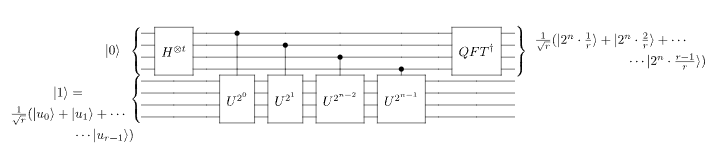


Şimdi Qiskit simülatörlerini kullanarak Shor algoritmasını göstereceğiz. Bu gösterim için $U$ için devreleri açıklama yapmadan sunacağız, ancak bölüm 4'te $U^{2^j}$ için devrelerin nasıl verimli bir şekilde oluşturulabileceğini tartışacağız.

## 3. Qiskit Uygulaması

Bu örnekte, $a=7$ ve $N=15$ için periyot bulma problemini çözeceğiz. $U$ için devreleri aşağıdaki gibi veriyoruz:

$$U|y\rangle = |ay\bmod 15\rangle $$

açıklama yapmadan. $U^x$'i oluşturmak için, devreyi $x$ kez tekrarlayacağız. Bir sonraki bölümde, bu devreleri verimli bir şekilde oluşturmak için genel bir yöntem ele alacağız. `c_amod15` işlevi, `a` için `power` kez tekrarlanan kontrollü U kapısını döndürür.

In [9]:
def c_amod15(a, power):
    """Mod 15 ile kontrollü çarpma"""

    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' 2, 4, 7, 8, 11 veya 13 olmalıdır.")
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4,11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U

8 adet sayma kübiti kullanacağız:

In [10]:
N_COUNT = 8
a = 7

Ayrıca QFT için devreyi de içe aktarıyoruz.

In [ ]:
def qft_dagger(n):
    """n-kubit QFTdagger, circ içindeki ilk n kubit"""
    qc = QuantumCircuit(n)
    # Swap işlemini unutmayalım
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

Bu yapı taşlarıyla Shor algoritması için devreyi kolayca oluşturabiliriz:

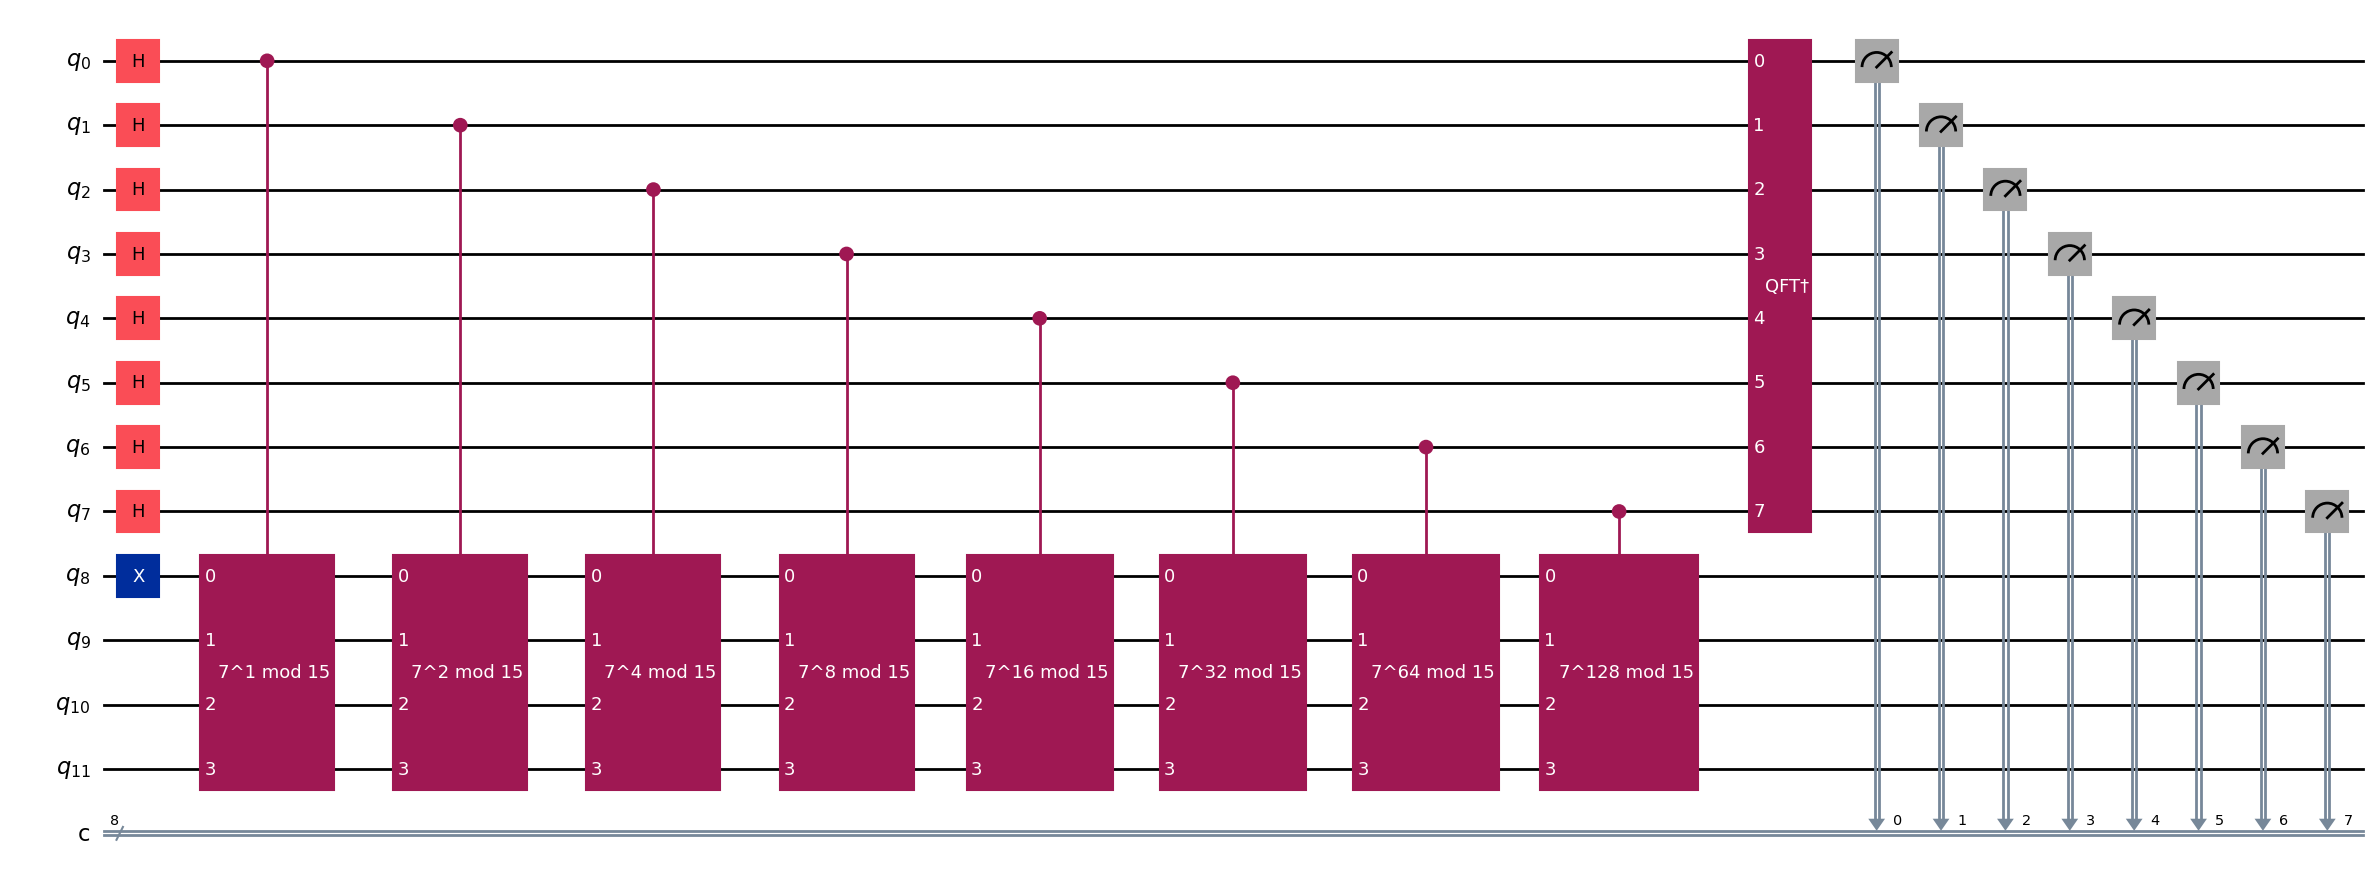

In [12]:
# N_COUNT sayma kübitleri ile QuantumCircuit oluşturun
# artı U'nun etki edeceği 4 kübit

qc = QuantumCircuit(N_COUNT + 4, N_COUNT)

# Sayma kuantum bitlerini başlat
# durumda |+>
for q in range(N_COUNT):
    qc.h(q)

# Ve durum |1>'deki yardımcı register
qc.x(N_COUNT)

# Kontrollü U işlemleri yapın
for q in range(N_COUNT):
    qc.append(c_amod15(a, 2**q), [q] + [i+N_COUNT for i in range(4)])

# Ters QFT uygulayın
qc.append(qft_dagger(N_COUNT), range(N_COUNT))

# Ölçüm yapın
qc.measure(range(N_COUNT), range(N_COUNT))
# Devreyi görselleştirin
qc.draw('mpl', fold=-1)

Şimdi ise ölçerek sonuca bakalım

/home/hyperranger/anaconda3/envs/quantumpc/lib/python3.13/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


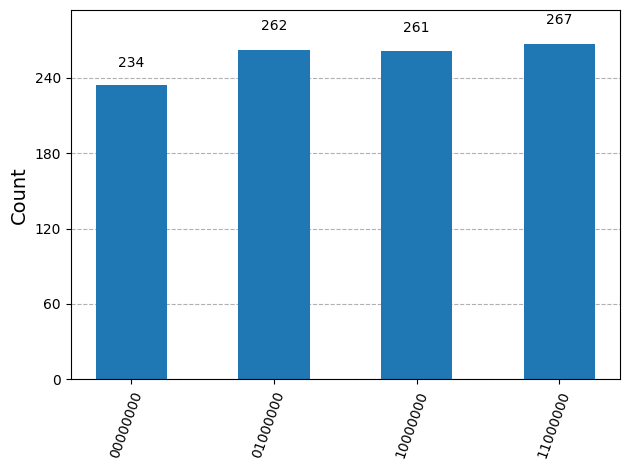

In [13]:
aer_sim = AerSimulator()
compiled_circ = transpile(qc, aer_sim)
result = aer_sim.run(compiled_circ).result()
counts = result.get_counts(qc)
plot_histogram(counts)

8 kuantum bitimiz olduğundan, bu sonuçlar ölçülen fazlara karşılık gelir:

In [18]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # İkili (2 tabanlı) sayıyı ondalık sayıya dönüştür
    phase = decimal/(2**N_COUNT)  # Karşılık gelen özdeğeri bulunuz.
    measured_phases.append(phase)
    # Bu değerleri tablomuzdaki satırlara ekle:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**N_COUNT} = {phase:.2f}"])

headers=["Register Çıktısı", "Faz"]
df = pd.DataFrame(rows, columns=headers)
print(df)

           Register Çıktısı             Faz
0  10000000(bin) = 128(dec)  128/256 = 0.50
1  00000000(bin) =   0(dec)    0/256 = 0.00
2  01000000(bin) =  64(dec)   64/256 = 0.25
3  11000000(bin) = 192(dec)  192/256 = 0.75


Artık kesir dizisi algoritmasını kullanarak $s$ ve $r$ değerlerini bulmaya çalışabiliriz. Python'da bu işlevsellik yerleşik olarak mevcuttur: `fractions` modülünü kullanarak bir float değerini `Fraction` nesnesine dönüştürebiliriz, örneğin:

In [19]:
Fraction(0.666)

Fraction(5998794703657501, 9007199254740992)

Bu, sonucu tam olarak veren kesirler verdiği için (bu durumda, `0.6660000...`), yukarıdaki gibi garip sonuçlar verebilir. `.limit_denominator()` yöntemini kullanarak, paydası belirli bir değerin altında olan ve float değerimize en yakın kesiri elde edebiliriz:

In [20]:
Fraction(0.666).limit_denominator(15)

Fraction(2, 3)

Çok daha iyi! Sıra (r) N'den küçük olmalıdır, bu nedenle maksimum paydayı `15` olarak ayarlayacağız:

In [21]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase,
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])

headers=["Faz", "Kesir", "r tahmini"]
df = pd.DataFrame(rows, columns=headers)
print(df)

    Faz Kesir  r tahmini
0  0.50   1/2          2
1  0.00   0/1          1
2  0.25   1/4          4
3  0.75   3/4          4


Ölçülen özdeğerlerden ikisinin bize doğru sonucu verdiğini görebiliriz: $r=4$, ve Shor algoritmasının başarısız olma ihtimali olduğunu görebiliriz. Bu kötü sonuçlar, $s = 0$ olduğu için veya $s$ ve $r$'nin asal çarpanları olmadığı ve $r$ yerine $r$'nin bir çarpanı verildiği için ortaya çıkmaktadır. Bunun en kolay çözümü, $r$ için tatmin edici bir sonuç elde edene kadar deneyi tekrarlamaktır.

## 4. Modüler Üs Alma

$U$'yu tekrar ederek $U^{2^j}$ kapılarını oluşturma yönteminin $j$ ile birlikte üstel olarak büyüdüğünü ve polinom zamanlı bir algoritma ile sonuçlanmayacağını fark etmiş olabilirsiniz. Operatörü oluşturmanın bir yolunu arıyoruz:

$$ U^{2^j}|y\rangle = |a^{2^j}y \bmod N \rangle $$

$j$ ile polinomik olarak büyür. Neyse ki,

$$ a^{2^j} \bmod N$$

hesaplaması verimli bir şekilde yapılabilir. Klasik bilgisayarlar, üstel sayıları hesaplamak için _tekrarlı kareleme_ olarak bilinen bir algoritma kullanabilir. Bizim durumumuzda, sadece $2^j$ biçimindeki üstel sayılarla uğraştığımız için, tekrarlı kareleme algoritması çok basit hale gelir:

In [22]:
def a2jmodN(a, j, N):
    """Tekrarlı kare alma işlemiyle a^{2^j} (mod N) değerini hesaplayın"""
    for _ in range(j):
        a = np.mod(a**2, N)
    return a

In [23]:
a2jmodN(7, 2049, 53)

np.int64(47)

Python'da verimli bir algoritma mümkünse, aynı algoritmayı kuantum bilgisayarda da kullanabiliriz. Ne yazık ki, $j$ ile polinomik olarak ölçeklenmesine rağmen, modüler üs alma devreleri basit değildir ve Shor algoritmasının darboğazını oluşturur. Yeni başlayanlar için uygun bir uygulama referans [1]'de bulunabilir.

## 5. Periyot Bulma Yöntemiyle Çarpanlara Ayırma

Tüm çarpanlara ayırma problemleri zor değildir; çift sayıları anında tespit edebilir ve çarpanlarından birinin 2 olduğunu bilebiliriz. Aslında, belirli kriterler vardır, ancak temel fikir iki büyük asal sayının çarpımını seçmektir.

Genel bir çarpanlara ayırma algoritması, en kötü senaryo için Shor'un periyot bulma yöntemini kullanmadan önce, tamsayıyı çarpanlara ayırmanın bir kısayolu olup olmadığını (sayı çift mi? Sayı $N = a^b$ şeklinde mi?) kontrol eder. Algoritmanın kuantum kısmına odaklanmayı hedeflediğimizden, doğrudan N'nin iki asal sayının çarpımı olduğu duruma geçeceğiz.

### Örnek: 15'in çarpanlarına ayırma

Az sayıda kubit üzerinde çarpanlarına ayırma örneği görmek için, hepimizin bildiği gibi, çok büyük olmayan asal sayılar 3 ve 5'in çarpımı olan 15'i çarpanlarına ayıracağız.

In [24]:
N = 15

İlk adım, $1$ ile $N-1$ arasında rastgele bir sayı, $a$, seçmektir:

In [25]:
np.random.seed(1)
a = randint(2, 15)
print(a)

7



Daha sonra bunun halihazırda $N$'ın önemsiz bir çarpanı olmadığını hızlıca kontrol ederiz:

In [26]:
math.gcd(a, N)  # a ve N'nin ortak bölenini kontrol edin

1

Harika. Şimdi a = 7 ve N = 15 için Shor’un mertebe bulma algoritmasını yapacağız. Ölçtüğümüz fazın s/r olacağını unutmayın:

$$ a^r \bmod N = 1 $$

ve s, 0 ile r−1 arasında rastgele bir tamsayıdır.

In [29]:
def qpe_amod15(a):
    """a*r mod 15 işlemi üzerinde kuantum faz kestirimi (QPE) gerçekleştirir.
    Argümanlar:
        a (int): a*r mod 15 denklemindeki 'a' değeri
    Döndürür:
        float: Ölçülen faz tahmini
    """
    N_COUNT = 8
    qc = QuantumCircuit(4 + N_COUNT, N_COUNT)
    for q in range(N_COUNT):
        qc.h(q)     # Sayma qubit’lerini |+> durumuna hazırla
    qc.x(N_COUNT) # Yardımcı kayıt qubit’ini |1> durumuna getir
    for q in range(N_COUNT): # Kontrollü-U işlemlerini uygula
        qc.append(c_amod15(a, 2**q),
                  [q] + [i + N_COUNT for i in range(4)])
    qc.append(qft_dagger(N_COUNT), range(N_COUNT)) # Ters QFT’yi uygula
    qc.measure(range(N_COUNT), range(N_COUNT))     # Ölçümleri yap
    # Simülasyon sonuçlarını al
    aer_sim = AerSimulator()
    # `memory=True` her ölçümü bir liste halinde saklama talimatı verir
    job = aer_sim.run(transpile(qc, aer_sim), shots=1, memory=True)
    readings = job.result().get_memory()
    print("Kayıt Okuması: " + readings[0])
    phase = int(readings[0], 2) / (2**N_COUNT)
    print(f"Eşleşen Faz: {phase}")
    return phase

Bu fazdan, r için kolayca bir tahmin bulabiliriz:

In [30]:
phase = qpe_amod15(a) # Faz = s/r
Fraction(phase).limit_denominator(15)

Kayıt Okuması: 00000000
Eşleşen Faz: 0.0


Fraction(0, 1)

In [31]:
frac = Fraction(phase).limit_denominator(15)
s, r = frac.numerator, frac.denominator
print(r)

1


Şimdi $r$’ye sahibiz; bunu $N$’in bir çarpanını bulmak için kullanabiliriz. Çünkü:

$$a^r \bmod N = 1 $$

ise:

$$(a^r - 1) \bmod N = 0 $$

yani $N$, $a^r-1$’i böler. Eğer $r$ aynı zamanda çift ise, o zaman:

$$a^r -1 = (a^{r/2}-1)(a^{r/2}+1)$$

(yani $r$ çift değilse bu yol ilerlemez; farklı bir $a$ değeriyle yeniden denememiz gerekir). Bu durumda, ya $gcd(N,\,a^{r/2}-1)$ ya da $gcd(N,\,a^{r/2}+1)$ değerlerinden birinin $N$’in doğru bir çarpanı olma olasılığı yüksektir [2]:


In [32]:
guesses = [math.gcd(a**(r//2)-1, N), math.gcd(a**(r//2)+1, N)]
print(guesses)

[15, 1]


Aşağıdaki hücre, en az bir tane 15’in çarpanını bulana dek algoritmayı tekrarlar. Hücrenin davranışını görmek için birkaç kez yeniden çalıştırmayı deneyin.

In [35]:
a = 7
FACTOR_FOUND = False
ATTEMPT = 0
while not FACTOR_FOUND:
    ATTEMPT += 1
    print(f"\nDENEME {ATTEMPT}:")
    phase = qpe_amod15(a)  # Faz = s/r
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator
    print(f"Sonuç: r = {r}")
    if phase != 0:
        # Çarpan tahminleri gcd(a^(r/2) ± 1, 15)
        guesses = [math.gcd(a**(r//2) - 1, N), math.gcd(a**(r//2) + 1, N)]
        print(f"Tahmini Çarpanlar: {guesses[0]} ve {guesses[1]}")
        for guess in guesses:
            if guess not in [1, N] and (N % guess) == 0:
                # Tahmin geçerli bir çarpan!
                print(f"*** Doğrusal olmayan çarpan bulundu: {guess} ***")
                FACTOR_FOUND = True


DENEME 1:
Kayıt Okuması: 00000000
Eşleşen Faz: 0.0
Sonuç: r = 1

DENEME 2:
Kayıt Okuması: 11000000
Eşleşen Faz: 0.75
Sonuç: r = 4
Tahmini Çarpanlar: 3 ve 5
*** Doğrusal olmayan çarpan bulundu: 3 ***
*** Doğrusal olmayan çarpan bulundu: 5 ***


In [36]:
assert (3 in guesses) or (5 in guesses)

## 6. Kaynakçalar

1. Stephane Beauregard, _Circuit for Shor's algorithm using 2n+3 qubits,_ [arXiv:quant-ph/0205095](https://arxiv.org/abs/quant-ph/0205095)

2. M. Nielsen and I. Chuang, _Quantum Computation and Quantum Information,_ Cambridge Series on Information and the Natural Sciences (Cambridge University Press, Cambridge, 2000). (Page 633)